Sames as training_mkl_04_cv except with much larger set of drugs to train on:

In [20]:
%run -m ipy_startup
%run -m ipy_logging
%run -m ipy_plotly
%run -m ipy_seaborn
%matplotlib inline
import tensorflow as tf
import edward as ed

from mgds.data_aggregation import api
from mgds.data_aggregation import database as db
from mgds.data_aggregation import source as src
from mgds.data_aggregation import data_type as dtyp
from mgds.data_modeling.nbfn import mkl as mkl
from mgds.data_modeling.nbfn import drugs as mgds_drugs
from mgds.data_modeling.nbfn import model_mkl04 as mklmodel
from mgds.data_modeling import constants as model_constants
from ml.api import trainer as ml_trainer

SEED = model_constants.SEED
RES_DIR = '/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large'

def rpath(filename):
    return os.path.join(RES_DIR, filename)

In [4]:
X_rppa, Y_rppa, df_rppa = mkl.get_tcga_modeling_data('brca')

2017-04-15 21:08:53,867:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/prep/tcga_v1_raw-data-matrices.pkl"
2017-04-15 21:08:53,867:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/prep/tcga_v1_raw-data-matrices.pkl"
2017-04-15 21:09:19,373:INFO:mgds.data_modeling.nbfn.mkl: Imputing 530 X values of 5406245
2017-04-15 21:09:19,373:INFO:mgds.data_modeling.nbfn.mkl: Imputing 530 X values of 5406245
2017-04-15 21:09:24,676:INFO:mgds.data_modeling.nbfn.mkl: Imputing 0 Y values of 68107
2017-04-15 21:09:24,676:INFO:mgds.data_modeling.nbfn.mkl: Imputing 0 Y values of 68107


In [5]:
target_drugs = list(np.unique(mgds_drugs.GDSC_PAPER_DRUGS + mgds_drugs.DEFAULT_DRUGS))
target_drugs[:10]

['17AAG',
 '5FLUOROURACIL',
 '5Z7OXOZEAENOL',
 '681640',
 'A443654',
 'A770041',
 'AC220',
 'AFATINIB',
 'AG014699',
 'AICAR']

In [4]:
# import imp
# imp.reload(mkl)

In [6]:
X_drug, Y_drug = mkl.get_rx_modeling_data(
    drugs=target_drugs, genes=X_rppa.columns.tolist(), 
    ge_src=src.CCLE_v1, site='BREAST'
)
# X_drug, Y_drug = mkl.get_rx_modeling_data(
#     drugs=target_drugs, genes=X_rppa.columns.tolist(), 
#     ge_src=src.GDSC_v2, site='BREAST'
# )
#X_drug, Y_drug = mkl.get_rx_modeling_data(drugs=target_drugs, genes=X_rppa.columns.tolist(), ge_src='agg')

2017-04-15 21:10:19,849:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/prep/mgds_v1_raw-features.pkl"
2017-04-15 21:10:19,849:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/prep/mgds_v1_raw-features.pkl"
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/ipykernel/ipkernel.py:196: PerformanceWarning:

indexing past lexsort depth may impact performance.

2017-04-15 21:10:37,325:INFO:mgds.data_modeling.nbfn.mkl: Removing 37 drugs of 233 due to having more than 30.0% null records
2017-04-15 21:10:37,325:INFO:mgds.data_modeling.nbfn.mkl: Removing 37 drugs of 233 due to having more than 30.0% null records


[Remove X records with null X values] Records before = 1473, Records after = 967, Records removed = 506 (%34.35)
[Remove Y records with null X values] Records before = 1473, Records after = 967, Records removed = 506 (%34.35)
[Remove X records with null Y values] Records before = 967, Records after = 639, Records removed = 328 (%33.92)
[Remove Y records with null Y values] Records before = 967, Records after = 639, Records removed = 328 (%33.92)


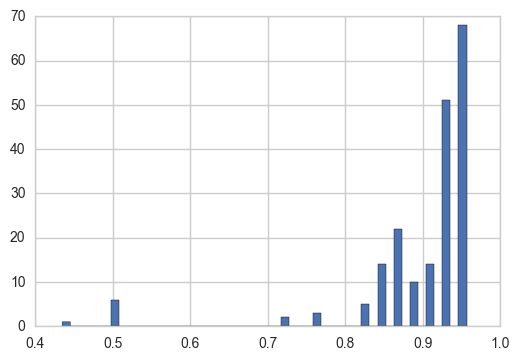

In [7]:
(Y_drug.notnull().sum(axis=0) / len(Y_drug)).hist(bins=50)

In [8]:
X_drug.shape, Y_drug.shape

((46, 13415), (46, 196))

In [9]:
X_rppa.shape, Y_rppa.shape

((403, 13415), (403, 169))

In [10]:
df_rppa.shape

(1105, 90637)

In [11]:
np.any(X_drug.isnull())

False

In [12]:
Y_drug.isnull().sum().sum() / Y_drug.values.ravel().shape[0]

0.098491570541259982

In [13]:
from sklearn.preprocessing import Imputer
Y_drug_imp = pd.DataFrame(Imputer(strategy='mean').fit_transform(Y_drug), index=Y_drug.index, columns=Y_drug.columns)

In [14]:
np.any(Y_drug_imp.isnull())

False

In [15]:
np.any(X_rppa.isnull())

False

In [16]:
np.any(Y_rppa.isnull())

False

# Modeling

In [16]:
# import imp
# imp.reload(mklmodel)
# imp.reload(ed_models)

In [17]:
# from ml.tensorflow import utilities as tf_utils
# tf.reset_default_graph()
# v = tf.contrib.distributions.StudentT(df=3., mu=0., sigma=.1).sample(100000)
# ax = pd.Series(tf_utils.tf_eval(v)).hist(bins=50)
# ax.set_yscale('symlog')

In [17]:
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from ml.edward import models as ed_models
from ml.api import trainer
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

def get_mkl_model(i):
    tf.reset_default_graph()
    model = mklmodel.MTKLModel(X_rppa.values, Y_rppa.values, gamma=None, print_kernel_stats=False)
    est = ed_models.BayesianModelEstimator(
        model, n_collect=1, n_print_progress=100, random_state=SEED, 
        fail_if_not_converged=False, max_steps=2500,
        inference_fn=ed.MAP
    )
    est.set_log_dir('/tmp/mkl4cv/{}'.format(i))
    return est
    
    
ests = {
    'ridge': lambda i: Pipeline([
        ('scale', StandardScaler()),
        ('est', MultiOutputRegressor(RidgeCV(alphas=np.logspace(-3, 6, 10))))
    ]),
    'pcareg': lambda i: Pipeline([
        ('scale', StandardScaler()),
        ('pca', PCA(n_components=10)),
        ('est', MultiOutputRegressor(LinearRegression()))
    ]),
    'mkl': get_mkl_model,
    'baseline': lambda i: MultiOutputRegressor(DummyRegressor(strategy='mean'))
}

cv = KFold(n_splits=5, random_state=SEED, shuffle=True).split(X_drug)

def fit_fn(est_name, est, X_train, Y_train, X_test, Y_test, fold):
    if est_name == 'mkl':
        est = est.fit(X_train.values, Y_train.values)
        return est
    else:
        return est.fit(X_train, Y_train)

config = trainer.TrainerConfig(refit=True, model_fit_fn=fit_fn)
cv_trainer = trainer.Trainer(config)

In [18]:
! rm -rf /tmp/mkl4cv/*
train_res = cv_trainer.train_regressors(X_drug, Y_drug_imp, ests, cv)

2017-04-15 21:11:30,698:INFO:ml.model.log: Running model baseline (DummyRegressor) on fold 1 ==> dim(X_train) = (36, 13415), dim(X_test) = (10, 13415), dim(Y_train) = (36, 196), dim(Y_test) = (10, 196)
2017-04-15 21:11:30,698:INFO:ml.model.log: Running model baseline (DummyRegressor) on fold 1 ==> dim(X_train) = (36, 13415), dim(X_test) = (10, 13415), dim(Y_train) = (36, 196), dim(Y_test) = (10, 196)
2017-04-15 21:11:30,775:INFO:ml.model.log: Running model mkl (BayesianModelEstimator) on fold 1 ==> dim(X_train) = (36, 13415), dim(X_test) = (10, 13415), dim(Y_train) = (36, 196), dim(Y_test) = (10, 196)
2017-04-15 21:11:30,775:INFO:ml.model.log: Running model mkl (BayesianModelEstimator) on fold 1 ==> dim(X_train) = (36, 13415), dim(X_test) = (10, 13415), dim(Y_train) = (36, 196), dim(Y_test) = (10, 196)


Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-04-15 21:11:36,776:INFO:root: On iteration 0 of at most 2500 (loss = 3859303.25, loss change = None)
2017-04-15 21:11:36,776:INFO:root: On iteration 0 of at most 2500 (loss = 3859303.25, loss change = None)
2017-04-15 21:11:37,343:INFO:root: On iteration 100 of at most 2500 (loss = 2478864.0, loss change = -6288.3251953125)
2017-04-15 21:11:37,343:INFO:root: On iteration 100 of at most 2500 (loss = 2478864.0, loss change = -6288.3251953125)
2017-04-15 21:11:38,014:INFO:root: On iteration 200 of at most 2500 (loss = 2006392.25, loss change = -4357.25)
2017-04-15 21:11:38,014:INFO:root: On iteration 200 of at most 2500 (loss = 2006392.25, loss change = -4357.25)
2017-04-15 21:11:38,505:INFO:root: On iteration 300 of at most 2500 (loss = 1649639.875, loss change = -3303.85009765625)
2017-04-15 21:11:38,505:INFO:root: On iteration 300 of at most 2500 (loss = 1649639.875, loss change = -3303.85009765625)
2017-04-15 21:11:39,095:INFO:root: On iteration 400 of at most 2500 (loss = 137938

Beginning model refitting


2017-04-15 21:12:59,922:INFO:root: On iteration 0 of at most 2500 (loss = 3862315.75, loss change = None)
2017-04-15 21:12:59,922:INFO:root: On iteration 0 of at most 2500 (loss = 3862315.75, loss change = None)
2017-04-15 21:13:00,465:INFO:root: On iteration 100 of at most 2500 (loss = 2493613.25, loss change = -5985.02490234375)
2017-04-15 21:13:00,465:INFO:root: On iteration 100 of at most 2500 (loss = 2493613.25, loss change = -5985.02490234375)
2017-04-15 21:13:00,986:INFO:root: On iteration 200 of at most 2500 (loss = 2027933.625, loss change = -4312.66259765625)
2017-04-15 21:13:00,986:INFO:root: On iteration 200 of at most 2500 (loss = 2027933.625, loss change = -4312.66259765625)
2017-04-15 21:13:01,490:INFO:root: On iteration 300 of at most 2500 (loss = 1674354.25, loss change = -3278.91259765625)
2017-04-15 21:13:01,490:INFO:root: On iteration 300 of at most 2500 (loss = 1674354.25, loss change = -3278.91259765625)
2017-04-15 21:13:02,010:INFO:root: On iteration 400 of at mo

In [19]:
from ml.api.results import predictions
d_pred = predictions.extract(train_res)
d_pred_melt = predictions.melt(train_res, d_pred)
d_pred_melt.head()

Actual  Fold     Model  Predicted  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                        
AU565             BREAST            -2.239748     1  baseline   -0.82205   
BT20              BREAST            -0.867087     1  baseline   -0.82205   
EFM19             BREAST            -0.957216     1  baseline   -0.82205   
HCC1500           BREAST             0.844980     1  baseline   -0.82205   
HCC1569           BREAST            -0.146932     1  baseline   -0.82205   

                                      Task  
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS         
AU565             BREAST             17AAG  
BT20              BREAST             17AAG  
EFM19             BREAST             17AAG  
HCC1500           BREAST             17AAG  
HCC1569           BREAST             17AAG

In [21]:
from ml.api.results import properties
est = properties.extract_refit_model_map(train_res)['mkl']

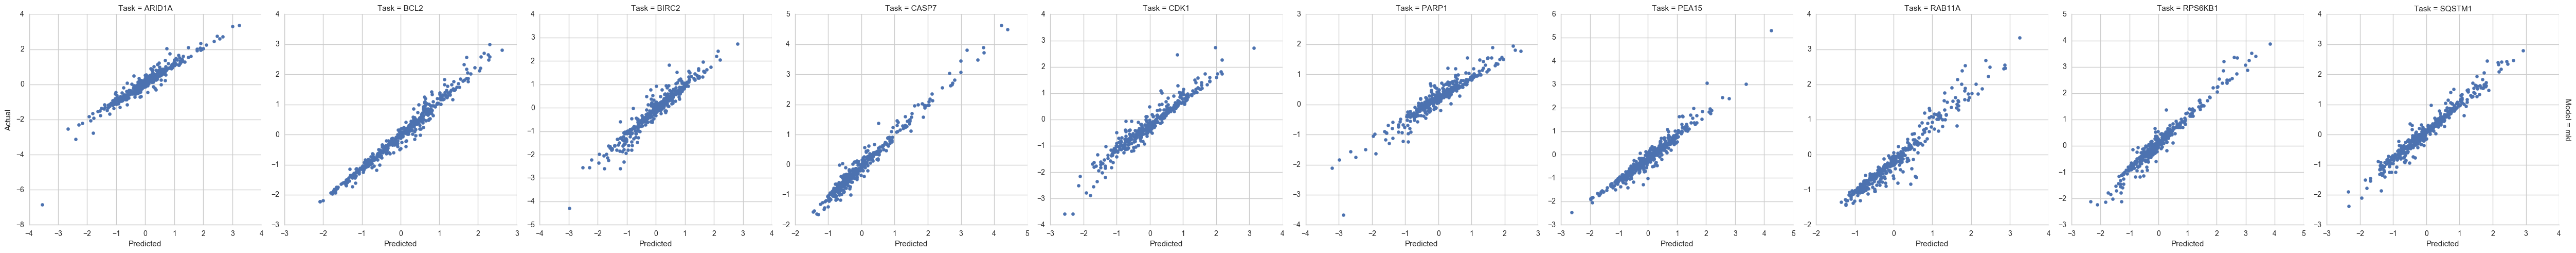

In [22]:
# Predictions on RPPA training data
Yp = pd.DataFrame(est.clf.get_tensor('qYR'), index=Y_rppa.index, columns=Y_rppa.columns)
d_pred_train = mkl.stack_predictions(Yp, Y_rppa).reset_index().assign(Model='mkl', Fold=0).rename(columns={'Pred': 'Predicted'})
tasks = d_pred_train['Task'].sample(n=10).values
predictions.visualize(train_res, d_pred_train[d_pred_train['Task'].isin(tasks)], share_axes=False)

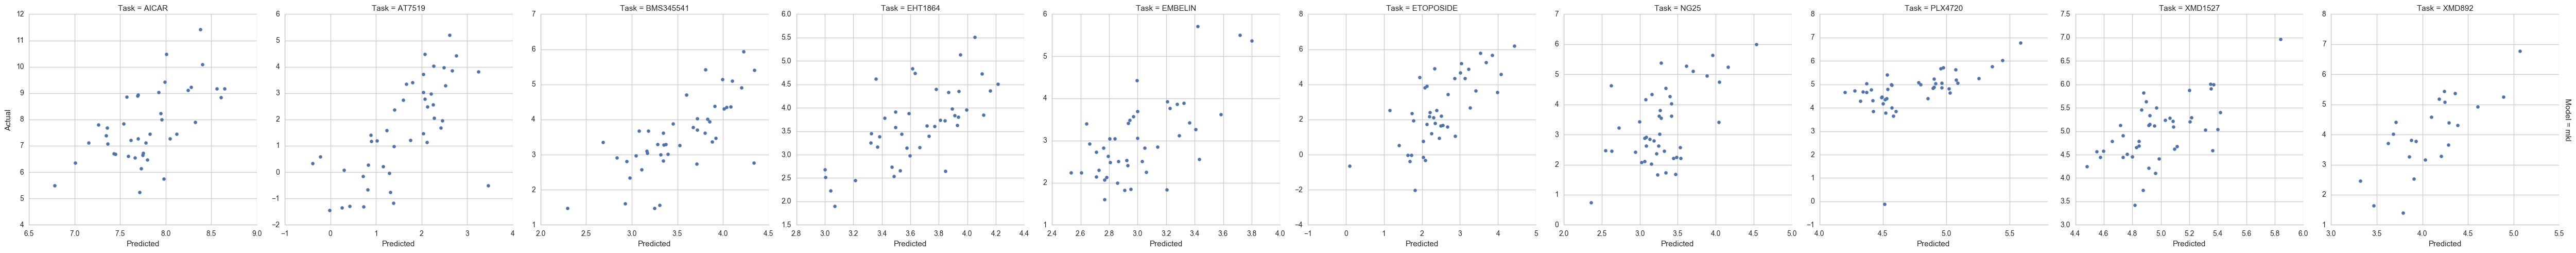

In [23]:
# Predictions on drug training data
Yp = est.clf.predict(X_drug.values)
d_pred_train = mkl.stack_predictions(Yp, Y_drug).reset_index().assign(Model='mkl', Fold=0).rename(columns={'Pred': 'Predicted'})
tasks = d_pred_train['Task'].sample(n=10, random_state=1).values
predictions.visualize(train_res, d_pred_train[d_pred_train['Task'].isin(tasks)], share_axes=False)

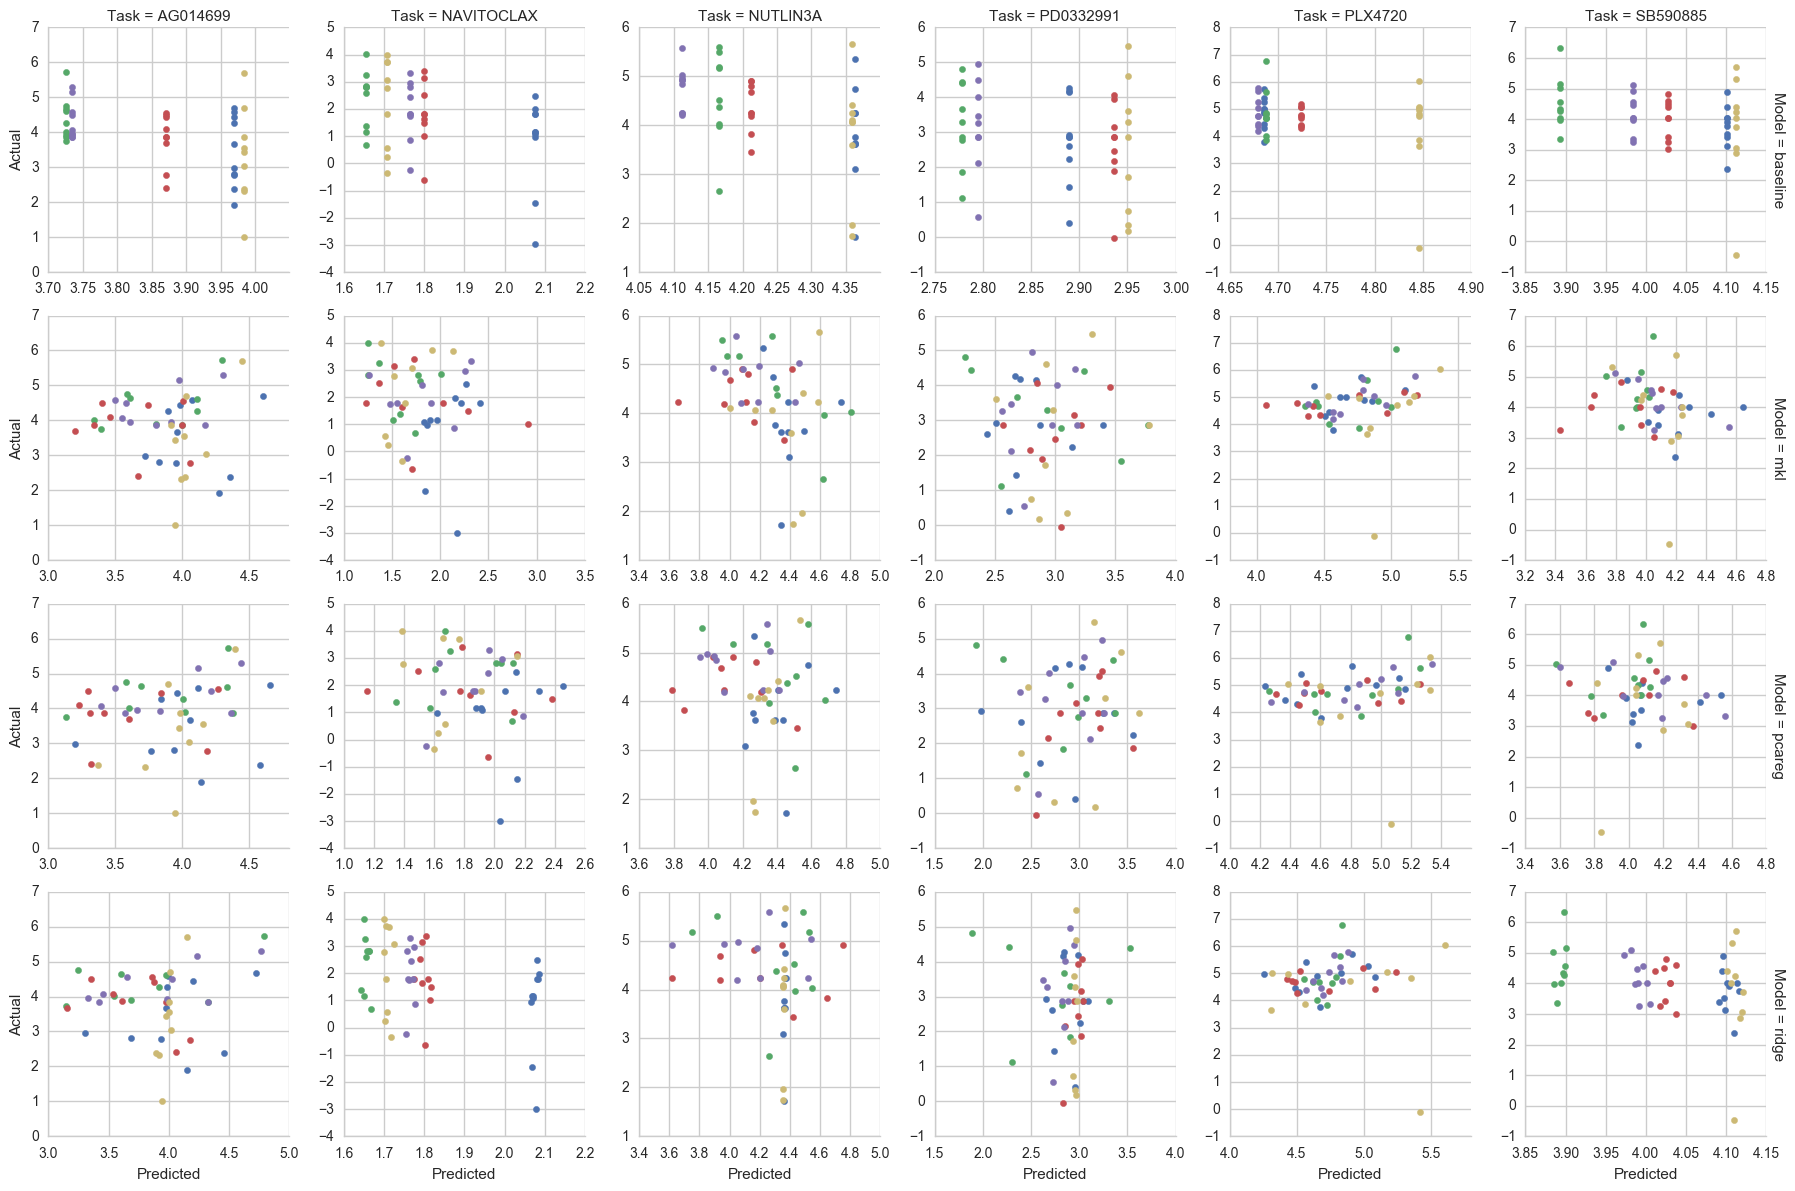

In [24]:
#tasks = d_pred_melt['Task'].sample(n=10).values
tasks = mgds_drugs.DEFAULT_DRUGS
predictions.visualize(train_res, d_pred_melt[d_pred_melt['Task'].isin(tasks)], share_axes=False, figsize=3)

In [25]:
from ml.api.results import performance
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr

def score_fn(y_true, y_pred):
    return {
        'pearson': y_true.corr(y_pred, method='pearson'),
        'spearman': y_true.corr(y_pred, method='spearman'),
        'r2_score': r2_score(y_true, y_pred),
        'pearson_p': pearsonr(y_true, y_pred)[1],
        'spearman_p': spearmanr(y_true, y_pred)[1]
    }
d_score = performance.extract(train_res, d_pred, score_fn, by_fold=False)
d_score = performance.melt(d_score)
d_score.head()

Model Fold   Task      Metric     Value
0  baseline  All  17AAG     pearson -0.290003
1  baseline  All  17AAG   pearson_p  0.050582
2  baseline  All  17AAG    r2_score -0.047791
3  baseline  All  17AAG    spearman -0.307595
4  baseline  All  17AAG  spearman_p  0.037570

In [27]:
from py_utils import plotly_utils
figs = performance.visualize(d_score, separate_by='Metric', kind='scatter', auto_plot=False)
for metric in figs:
    filename = rpath('perf_scatter_{}.html'.format(metric))
    plty.offline.plt(figs[metric], filename=filename)
    print(filename)
[plotly_utils.iplot(fig) for fig in figs.values()]

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/196_drugs/perf_scatter_r2_score.html
/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/196_drugs/perf_scatter_spearman_p.html
/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/196_drugs/perf_scatter_pearson_p.html
/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/196_drugs/perf_scatter_pearson.html
/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/196_drugs/perf_scatter_spearman.html


[None, None, None, None, None]

In [34]:
def plot_performance_metric(d_score, metric=None, plot_in_notebook=False):
    title = 'Performance Scores'
    if metric is not None:
        d_score = d_score[d_score['Metric'] == metric]
        title = metric
    
    fig = performance.visualize(d_score, separate_by=None, auto_plot=False, layout_kwargs={'title': title})['All']
    filename = rpath('perf_box_{}.html'.format(metric if metric else 'all'))
    plty.offline.plt(fig, filename=filename)
    print(filename)
    if plot_in_notebook:
        plty.offline.iplt(fig)

In [29]:
plot_performance_metric(d_score, plot_in_notebook=True)

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/196_drugs/perf_box_all.html


In [31]:
plot_performance_metric(d_score, metric='pearson')

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/196_drugs/perf_box_pearson.html


In [32]:
plot_performance_metric(d_score, metric='spearman')

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/196_drugs/perf_box_spearman.html


In [33]:
plot_performance_metric(d_score, metric='pearson_p')

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/196_drugs/perf_box_pearson_p.html


# Drug Selection

Based on performance above:

In [35]:
d_score.head()

Model Fold   Task      Metric     Value
0  baseline  All  17AAG     pearson -0.290003
1  baseline  All  17AAG   pearson_p  0.050582
2  baseline  All  17AAG    r2_score -0.047791
3  baseline  All  17AAG    spearman -0.307595
4  baseline  All  17AAG  spearman_p  0.037570

In [36]:
def get_most_predictable_tasks(metric):
    assert np.all(d_score['Fold'] == 'All')
    d_top_perf = d_score.set_index(['Model', 'Task', 'Metric'])['Value'].unstack()
    d_top_perf = d_top_perf[(d_top_perf[metric] >= 0) & (d_top_perf['{}_p'.format(metric)] <= .05)]
    return d_top_perf
d_top_perf = get_most_predictable_tasks('spearman')
d_top_perf

Metric                 pearson     pearson_p  r2_score  spearman    spearman_p
Model Task                                                                    
mkl   AFATINIB        0.539522  1.091922e-04  0.278610  0.455252  1.477945e-03
      AP24534         0.284163  5.563179e-02  0.073469  0.301672  4.160334e-02
      AT7519          0.440961  2.159942e-03  0.178670  0.488883  5.658503e-04
      AZD7762         0.581579  2.247726e-05  0.331630  0.537491  1.172399e-04
      BLEOMYCIN50UM   0.584477  1.999413e-05  0.329600  0.597243  1.177697e-05
      BMS345541       0.360383  1.388337e-02  0.121958  0.391748  7.094135e-03
      BX795           0.470038  9.807225e-04  0.217977  0.458702  1.345256e-03
      BX912           0.423596  3.352821e-03  0.176527  0.337722  2.170977e-02
      CETUXIMAB       0.633662  2.279013e-06  0.358871  0.657637  6.848638e-07
      CH5424802       0.378456  9.502475e-03  0.134287  0.298958  4.356572e-02
      CHIR99021       0.293533  4.771450e-02  0.081681  0.345034  1.885653e-02
      CISPLATIN       0.341832  2.006466e-02  0.115865  0.297577  4.459266e-02
      CP724714        0.414877  4.145931e-03  0.171924  0.356566  1.500185e-02
      GSK1070916      0.501599  3.833812e-04  0.235569  0.489315  5.585581e-04
      GSK690693       0.251816  9.136788e-02  0.054855  0.376303  9.952328e-03
      GW2580          0.473043  9.002736e-04  0.186269  0.342380  1.985340e-02
      HG511301        0.441289  2.141634e-03  0.189782  0.341414  2.022700e-02
      KIN001102       0.305901  3.868933e-02  0.088130  0.417713  3.871659e-03
      KIN001236       0.322808  2.866331e-02  0.099778  0.322427  2.886250e-02
      KIN001270       0.479630  7.441859e-04  0.201181  0.406735  5.030265e-03
      LY317615        0.252457  9.051866e-02  0.063326  0.316137  3.232521e-02
      MLN4924         0.280602  5.890415e-02  0.078251  0.307573  3.758480e-02
      NPK76II721      0.488297  5.758885e-04  0.216337  0.409880  4.670851e-03
      OLAPARIB        0.400583  5.803525e-03  0.159338  0.360321  1.390106e-02
      PD0325901       0.306147  3.852525e-02  0.093461  0.410021  4.655284e-03
      PFI1            0.588914  1.667693e-05  0.273494  0.477580  7.899484e-04
      PHA793887       0.442250  2.088661e-03  0.186933  0.447480  1.820310e-03
      PLX4720         0.206393  1.687684e-01  0.033191  0.389132  7.521115e-03
      QLXII47         0.234145  1.173011e-01  0.052862  0.299732  4.299844e-02
      RDEA119         0.431314  2.765398e-03  0.184480  0.501930  3.794453e-04
...                        ...           ...       ...       ...           ...
ridge GENENTECHCPD10  0.339678  2.091334e-02  0.112188  0.398717  6.057590e-03
      GSK1070916      0.527868  1.631975e-04  0.264991  0.538345  1.137910e-04
      GSK269962A      0.385398  8.169031e-03  0.146097  0.318137  3.118880e-02
      GSK690693       0.364456  1.276928e-02  0.131917  0.412817  4.355730e-03
      GW2580          0.429026  2.929288e-03  0.182100  0.390242  7.337260e-03
      KIN001102       0.359033  1.427064e-02  0.122879  0.402603  5.538965e-03
      KIN001270       0.316391  3.217903e-02  0.080765  0.387061  7.874788e-03
      LAQ824          0.212149  1.569401e-01  0.026135  0.325881  2.709634e-02
      METHOTREXATE    0.243681  1.026901e-01  0.049913  0.301775  4.152985e-02
      MP470           0.345135  1.881960e-02  0.109089  0.400975  5.751374e-03
      NPK76II721      0.398952  6.025046e-03  0.150686  0.369669  1.145542e-02
      OLAPARIB        0.511237  2.825015e-04  0.254077  0.450046  1.700208e-03
      PD0325901       0.287261  5.290490e-02  0.068930  0.399148  5.998070e-03
      PD173074        0.218681  1.442668e-01  0.004306  0.308581  3.693113e-02
      PFI1            0.701504  5.615845e-08  0.434477  0.691852  1.010757e-07
      PHA793887       0.501936  3.793672e-04  0.246264  0.449207  1.738677e-03
      PIPERLONGUMINE  0.542267  9.911928e-05  0.289839  0.447480  1.820310e-03
      PLX4720        -0.023422  8.772102e-01 -0.11

In [41]:
pd.set_option('display.max_rows', 10000)
d_top_perf.reset_index().groupby('Task')['Model'].unique()

Task
5Z7OXOZEAENOL          [pcareg, ridge]
AFATINIB                  [mkl, ridge]
AP24534           [mkl, pcareg, ridge]
AS601245                      [pcareg]
AT7519            [mkl, pcareg, ridge]
AZD7762           [mkl, pcareg, ridge]
BLEOMYCIN50UM     [mkl, pcareg, ridge]
BMS345541         [mkl, pcareg, ridge]
BMS708163              [pcareg, ridge]
BX795             [mkl, pcareg, ridge]
BX912             [mkl, pcareg, ridge]
CEP701                 [pcareg, ridge]
CETUXIMAB         [mkl, pcareg, ridge]
CH5424802                 [mkl, ridge]
CHIR99021         [mkl, pcareg, ridge]
CI1040                        [pcareg]
CISPLATIN         [mkl, pcareg, ridge]
CP724714          [mkl, pcareg, ridge]
CYTARABINE                    [pcareg]
DMOG                   [pcareg, ridge]
EHT1864                [pcareg, ridge]
FK866                  [pcareg, ridge]
GENENTECHCPD10         [pcareg, ridge]
GSK1070916        [mkl, pcareg, ridge]
GSK269962A             [pcareg, ridge]
GSK690693         [m

In [55]:
d_top_perf.loc['pcareg'].index.get_level_values('Task')

Index(['5Z7OXOZEAENOL', 'AP24534', 'AS601245', 'AT7519', 'AZD7762',
       'BLEOMYCIN50UM', 'BMS345541', 'BMS708163', 'BX795', 'BX912', 'CEP701',
       'CETUXIMAB', 'CHIR99021', 'CI1040', 'CISPLATIN', 'CP724714',
       'CYTARABINE', 'DMOG', 'EHT1864', 'FK866', 'GENENTECHCPD10',
       'GSK1070916', 'GSK269962A', 'GSK690693', 'GW2580', 'HG511301', 'HG6641',
       'IBET762', 'JW7241', 'KIN001102', 'KIN001270', 'METHOTREXATE',
       'MIDOSTAURIN', 'MP470', 'NPK76II721', 'OLAPARIB', 'PD0325901',
       'PD173074', 'PFI1', 'PHA793887', 'PIPERLONGUMINE', 'PLX4720', 'RDEA119',
       'RTRAIL', 'SB52334', 'TEMOZOLOMIDE', 'TG101348', 'THAPSIGARGIN',
       'TRAMETINIB', 'WZ3105', 'XAV939', 'XMD132', 'Y39983', 'YK4279',
       'ZM447439', 'ZSTK474'],
      dtype='object', name='Task')

In [70]:
top_drugs = d_top_perf.loc['mkl'].index.get_level_values('Task')
top_drugs

Index(['AFATINIB', 'AP24534', 'AT7519', 'AZD7762', 'BLEOMYCIN50UM',
       'BMS345541', 'BX795', 'BX912', 'CETUXIMAB', 'CH5424802', 'CHIR99021',
       'CISPLATIN', 'CP724714', 'GSK1070916', 'GSK690693', 'GW2580',
       'HG511301', 'KIN001102', 'KIN001236', 'KIN001270', 'LY317615',
       'MLN4924', 'NPK76II721', 'OLAPARIB', 'PD0325901', 'PFI1', 'PHA793887',
       'PLX4720', 'QLXII47', 'RDEA119', 'RTRAIL', 'TG101348', 'TPCA1',
       'TRAMETINIB', 'XAV939', 'XMD1185H', 'XMD132', 'Y39983', 'YK4279',
       'ZSTK474'],
      dtype='object', name='Task')

# Effects

In [71]:
from ml.api.results import properties
est = properties.extract_refit_model_map(train_res)['mkl']
qW = est.clf.get_tensor('qW')

In [72]:
W = pd.DataFrame(qW, index=Y_rppa.columns, columns=Y_drug.columns)
W.index.name = 'RPPA'
W.columns.name = 'Drug'
W.head()

Drug       17AAG  5FLUOROURACIL  5Z7OXOZEAENOL    681640     AC220  \
RPPA                                                                 
ABL1    0.160813   1.760286e-07      -0.000002  0.000072 -0.000014   
ACACA   0.000012   6.942794e-02       0.024567  0.000217 -0.000058   
ACVRL1  0.036236  -1.125261e-05       0.002808  0.000014  0.000004   
ADAR    0.000007  -6.054373e-02       0.000001  0.002615 -0.000003   
AKT1   -0.000037   1.682939e-02       0.000107  0.000003  0.091430   

Drug        AFATINIB  AG014699     AICAR  AKTINHIBITORVIII    AMG706  \
RPPA                                                                   
ABL1   -7.604130e-02  0.044273  0.096607          0.000002  0.111440   
ACACA  -4.545605e-02 -0.000022 -0.010185         -0.066891  0.000016   
ACVRL1  8.552851e-06 -0.072405 -0.004796          0.088747  0.000016   
ADAR   -9.419136e-07 -0.000008 -0.000005          0.000022  0.162846   
AKT1   -3.216787e-05 -0.000013  0.089306         -0.043090 -0.000672   

Drug        ...        XMD1499   XMD1527    XMD892    Y39983        YK4279  \
RPPA        ...                                                              
ABL1        ...      -0.000005 -0.000029  0.000019 -0.000002  5.233847e-04   
ACACA       ...       0.000010  0.000010 -0.009842  0.000019 -1.131004e-05   
ACVRL1      ...      -0.000002  0.000061 -0.000013  0.000043 -1.333631e-05   
ADAR        ...       0.000001  0.000003  0.165340  0.000007 -1.167802e-05   
AKT1        ...      -0.000052 -0.000041  0.128875 -0.000006 -9.685509e-07   

Drug       YM155  YM201636      ZG10  ZM447439       ZSTK474  
RPPA                                                          
ABL1   -0.000061 -0.000005  0.000016  0.062005 -2.582837e-05  
ACACA   0.000016 -0.108148 -0.000064  0.106439 -5.576956e-02  
ACVRL1  0.000003  0.000010  0.000022  0.016287 -1.197422e-06  
ADAR   -0.050336 -0.000013 -0.000020  0.000001 -3.158451e-05  
AKT1    0.000004 -0.003255 -0.000006 -0.000001  1.572007e-07  

[5 rows x 196 columns]

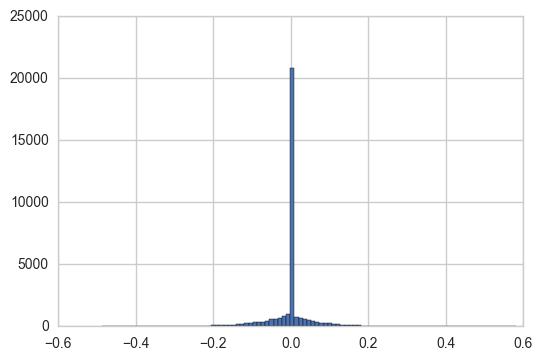

In [59]:
pd.Series(W.values.ravel()).hist(bins=100)

In [80]:
weight_cutoff = .1

In [81]:
W.head()

Drug       17AAG  5FLUOROURACIL  5Z7OXOZEAENOL    681640     AC220  \
RPPA                                                                 
ABL1    0.160813   1.760286e-07      -0.000002  0.000072 -0.000014   
ACACA   0.000012   6.942794e-02       0.024567  0.000217 -0.000058   
ACVRL1  0.036236  -1.125261e-05       0.002808  0.000014  0.000004   
ADAR    0.000007  -6.054373e-02       0.000001  0.002615 -0.000003   
AKT1   -0.000037   1.682939e-02       0.000107  0.000003  0.091430   

Drug        AFATINIB  AG014699     AICAR  AKTINHIBITORVIII    AMG706  \
RPPA                                                                   
ABL1   -7.604130e-02  0.044273  0.096607          0.000002  0.111440   
ACACA  -4.545605e-02 -0.000022 -0.010185         -0.066891  0.000016   
ACVRL1  8.552851e-06 -0.072405 -0.004796          0.088747  0.000016   
ADAR   -9.419136e-07 -0.000008 -0.000005          0.000022  0.162846   
AKT1   -3.216787e-05 -0.000013  0.089306         -0.043090 -0.000672   

Drug        ...        XMD1499   XMD1527    XMD892    Y39983        YK4279  \
RPPA        ...                                                              
ABL1        ...      -0.000005 -0.000029  0.000019 -0.000002  5.233847e-04   
ACACA       ...       0.000010  0.000010 -0.009842  0.000019 -1.131004e-05   
ACVRL1      ...      -0.000002  0.000061 -0.000013  0.000043 -1.333631e-05   
ADAR        ...       0.000001  0.000003  0.165340  0.000007 -1.167802e-05   
AKT1        ...      -0.000052 -0.000041  0.128875 -0.000006 -9.685509e-07   

Drug       YM155  YM201636      ZG10  ZM447439       ZSTK474  
RPPA                                                          
ABL1   -0.000061 -0.000005  0.000016  0.062005 -2.582837e-05  
ACACA   0.000016 -0.108148 -0.000064  0.106439 -5.576956e-02  
ACVRL1  0.000003  0.000010  0.000022  0.016287 -1.197422e-06  
ADAR   -0.050336 -0.000013 -0.000020  0.000001 -3.158451e-05  
AKT1    0.000004 -0.003255 -0.000006 -0.000001  1.572007e-07  

[5 rows x 196 columns]

In [82]:
layout = dict(
    title='RPPA Weights by Predictive Task (ie Drug)',
    width=1000, height=600,
    margin=dict(l=120)
)
fig = W.applymap(lambda v: np.nan if abs(v) <= weight_cutoff else v)\
    .iplot(kind='heatmap', colorscale='Spectral', asFigure=True, layout=layout)
filename = rpath('rppa_weight_all.html')
plty.offline.plt(fig, filename=filename)
print(filename)
plty.offline.iplt(fig)

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/196_drugs/rppa_weight_all.html


In [83]:
layout = dict(
    title='RPPA Weights by Predictive Task (ie Drug)<br>* Highly predictable drugs only',
    width=1000, height=600,
    margin=dict(l=120)
)
fig = W[top_drugs].applymap(lambda v: np.nan if abs(v) < weight_cutoff else v)\
    .iplot(kind='heatmap', colorscale='Spectral', asFigure=True, layout=layout)
filename = rpath('rppa_weight_best.html')
plty.offline.plt(fig, filename=filename)
print(filename)
plty.offline.iplt(fig)

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/196_drugs/rppa_weight_best.html


In [86]:
sorted(top_drugs.values)

['AFATINIB',
 'AP24534',
 'AT7519',
 'AZD7762',
 'BLEOMYCIN50UM',
 'BMS345541',
 'BX795',
 'BX912',
 'CETUXIMAB',
 'CH5424802',
 'CHIR99021',
 'CISPLATIN',
 'CP724714',
 'GSK1070916',
 'GSK690693',
 'GW2580',
 'HG511301',
 'KIN001102',
 'KIN001236',
 'KIN001270',
 'LY317615',
 'MLN4924',
 'NPK76II721',
 'OLAPARIB',
 'PD0325901',
 'PFI1',
 'PHA793887',
 'PLX4720',
 'QLXII47',
 'RDEA119',
 'RTRAIL',
 'TG101348',
 'TPCA1',
 'TRAMETINIB',
 'XAV939',
 'XMD1185H',
 'XMD132',
 'Y39983',
 'YK4279',
 'ZSTK474']

'/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/196_drugs/pred_top_drugs.png'

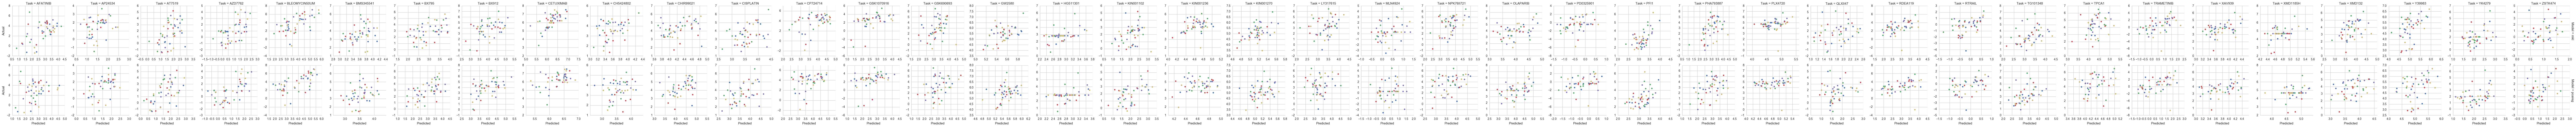

In [85]:
d_plt = d_pred_melt[d_pred_melt['Task'].isin(top_drugs)]
d_plt = d_plt[d_plt['Model'].isin(['pcareg', 'mkl'])]
predictions.visualize(train_res, d_plt, share_axes=False, figsize=3)
filename = rpath('pred_top_drugs.png')
plt.savefig(filename)
filename

In [105]:
def plot_single_drug(d, drug, model):
    d = d[d['Task'] == drug]
    d = d[d['Model'] == model]
    trace = go.Scatter(
        x=d['Predicted'],
        y=d['Actual'],
        mode='markers',
        text=d.reset_index()['CELL_LINE_ID:MGDS']
    )
    layout = go.Layout(
        title='Predictions (Model = "{}", Drug = "{}")'.format(model, drug),
        hovermode='closest'
    )
    fig = go.Figure(data=[trace], layout=layout)
    filename = rpath('pred_best_{}_{}.html'.format(drug, model))
    plty.offline.plt(fig, filename=filename)
    print(filename)
    plty.offline.iplt(fig)

sens_drugs = ['TRAMETINIB', 'RTRAIL', 'PD0325901', 'MLN4924', 'AZD7762']

for drug in sens_drugs:
    plot_single_drug(d_pred_melt, drug, 'mkl')
    

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/196_drugs/pred_best_TRAMETINIB_mkl.html


/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/196_drugs/pred_best_RTRAIL_mkl.html


/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/196_drugs/pred_best_PD0325901_mkl.html


/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/196_drugs/pred_best_MLN4924_mkl.html


/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/196_drugs/pred_best_AZD7762_mkl.html


In [97]:
# These drugs were selected by looking for negative value predictions in the above
sens_drugs = ['TRAMETINIB', 'RTRAIL', 'PD0325901', 'MLN4924', 'AZD7762']
layout = dict(
    title='RPPA Weights by Predictive Task (ie Drug)<br>* Highly predictable AND sensitive drugs',
    width=1000, height=300,
    margin=dict(l=120)
)
fig = W[sens_drugs].applymap(lambda v: np.nan if abs(v) < weight_cutoff else v)\
    .iplot(kind='heatmap', colorscale='Spectral', asFigure=True, layout=layout)
filename = rpath('rppa_weight_best_and_sensitive.html')
plty.offline.plt(fig, filename=filename)
print(filename)
plty.offline.iplt(fig)

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/196_drugs/rppa_weight_best_and_sensitive.html


# KL Comparison to Other Methods

In [98]:
def get_coef_array(multi_est):
    d_coef = []
    for est in multi_est.estimators_:
        d_coef.append(est.coef_)
    return pd.DataFrame(d_coef, index=Y_drug.columns, columns=X_drug.columns)

### Lasso

In [100]:
# from ml.api.results import properties
# est = properties.extract_refit_model_map(train_res)['lasso']

# d_coef = get_coef_array(est.clf.named_steps['est'])
# d_coef.head()

In [101]:
# has_pos = d_coef.abs().sum(axis=0)
# d_coef_top = d_coef[list(has_pos[has_pos > 0].index.values)]
# print(d_coef_top.shape)
# layout = dict(
#     title='Lasso Coefficients on Most Predictable Drugs',
#     margin=dict(l=100)
# )
# fig = d_coef_top.T.applymap(lambda v: np.nan if np.isclose(v, 0) else v)\
#     .iplot(kind='heatmap', colorscale='Spectral', asFigure=True, layout=layout)
# plty.offline.iplt(fig)
# filename = rpath('lasso_weight.html')
# plty.offline.plt(fig, filename=filename)
# print(filename)

### Ridge

In [102]:
from ml.api.results import properties
est = properties.extract_refit_model_map(train_res)['ridge']

d_coef = get_coef_array(est.clf.named_steps['est'])
d_coef.head()

A1BG       A2M     A2ML1    A4GALT     A4GNT      AAAS  \
Drug                                                                        
17AAG         -0.000162  0.000465  0.000144 -0.000177 -0.000359 -0.000420   
5FLUOROURACIL -0.000632  0.001117 -0.002069  0.000452  0.000394  0.000252   
5Z7OXOZEAENOL  0.000692 -0.000194  0.000072 -0.000008 -0.000921 -0.000627   
681640        -0.000277 -0.000323  0.000187  0.000087 -0.000354  0.000072   
AC220          0.000058 -0.001522  0.000346  0.000373 -0.000269  0.000264   

                   AACS     AADAC   AADACL2     AADAT    ...       ZSWIM7  \
Drug                                                     ...                
17AAG          0.000093 -0.000336  0.000127 -0.000563    ...     0.000200   
5FLUOROURACIL  0.000122 -0.000677  0.000754  0.001387    ...    -0.000259   
5Z7OXOZEAENOL  0.000143 -0.000062 -0.000086 -0.000254    ...     0.000083   
681640        -0.000261 -0.000383  0.000380 -0.000400    ...    -0.000334   
AC220         -0.000151 -0.000497  0.000243 -0.000252    ...    -0.000535   

                 ZSWIM8     ZUFSP     ZWINT      ZXDC    ZYG11A    ZYG11B  \
Drug                                                                        
17AAG         -0.000194 -0.000886  0.000556 -0.001163  0.000608 -0.000278   
5FLUOROURACIL -0.000035  0.000625  0.000181  0.000877 -0.001238 -0.000481   
5Z7OXOZEAENOL -0.000055 -0.000397 -0.000302 -0.000467  0.000498  0.000093   
681640         0.000418 -0.000220 -0.000320 -0.000043  0.000174 -0.000033   
AC220         -0.001433  0.000197 -0.000168 -0.000143 -0.000046 -0.001114   

                    ZYX     ZZEF1      ZZZ3  
Drug                                         
17AAG         -0.000143 -0.000508  0.000163  
5FLUOROURACIL  0.001059  0.002393 -0.000237  
5Z7OXOZEAENOL -0.000126  0.000082 -0.000305  
681640        -0.000058 -0.000153 -0.000221  
AC220         -0.000133  0.000380  0.000286  

[5 rows x 13415 columns]

In [103]:
mean_coef = d_coef.abs().mean(axis=0).sort_values(ascending=False)
d_coef_top = d_coef[list(mean_coef.head(500).index.values)]
layout = dict(
    title='Ridge Coefficients on Most Predictable Drugs',
    margin=dict(l=100)
)
fig = d_coef_top.T.applymap(lambda v: np.nan if np.isclose(v, 0) else v)\
    .iplot(kind='heatmap', colorscale='Spectral', asFigure=True, layout=layout)
plty.offline.iplt(fig)
filename = rpath('ridge_weight.html')
plty.offline.plt(fig, filename=filename)
print(filename)

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/196_drugs/ridge_weight.html


# Graveyard

In [175]:
#known_drugs = ['']
# W['NUTLIN3A'].abs().sort_values().tail(25)
# W['AG014699'].abs().sort_values().tail(25)
# W['PLX4720'].abs().sort_values().tail(25)
# W['SB590885'].abs().sort_values().tail(25)
#W['PD0332991'].abs().sort_values().tail(25)
#W['PLX4720'].abs().sort_values().tail(25)
